In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from tqdm.auto import tqdm

In [3]:
import data
import utils

In [4]:
readerTypes = [data.FccPmData]
targets = ['PM']

In [5]:
!mkdir -p models_clean_randgroup

In [6]:
def get_group_constraints(groups):
    interaction_constraints = []
    i=0
    for g in groups:
        interaction_constraints.append(list(range(i, i+len(g))))
        i += len(g)
    return interaction_constraints

In [7]:
mse_collector = {}

for ReaderType, target in zip(readerTypes, targets):
    reader = ReaderType('data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')
    reader.readAndCache()
    print("---------")
    print("Dataset:", reader.name)
    cols = reader.cols
    ncols = len(cols)

    trainer = utils.Trainer(
        cache_dir='models_clean',
        default_params={
            'objective': 'regression',
            'metric': 'mse',
            'boosting': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'verbose': -1,
            'device': 'cpu',
            'lambda_l2': 0.003,
            'early_stopping_round': 10,
            'num_boost_round': 100,
        },
        nocache_params={
            'num_threads': 20,
        }
    )
    evaluator = utils.Evaluator(reader, target)
    
    data_mse = {}
    
    print("Calculating full model mse...")
    trainData = utils.TrainingData(reader, target, columns=cols)
    booster = trainer.train_model(trainData)
    new_mse = evaluator.get_model_mse(booster)
    data_mse['base_mse'] = evaluator.base_mse
    data_mse['features_e'] = {'ngroups': 1, 'mse':new_mse}
    
    print("Calculating E^r model mse...")
    booster = trainer.train_model(trainData, {
        'interaction_constraints': [[i] for i in range(len(reader.cols))]
    })
    new_mse = evaluator.get_model_mse(booster)
    data_mse['features_er'] = {'ngroups': len(reader.cols), 'mse':new_mse}
    mse_collector[reader.name] = data_mse
    
    #e_r semantic groups
    if reader.groups is not None:
        print("Calculating semantic group E^r mse...")
        trainData = utils.TrainingData(reader, target, columns=[i for g in reader.groups.values() for i in g])
        booster = trainer.train_model(trainData, {
            'interaction_constraints': get_group_constraints(reader.groups),
        })
        new_mse = evaluator.get_model_mse(booster)
        data_mse['semantic_groups'] = {'ngroups': len(reader.groups), 'mse':new_mse}
    
    for groupsize in [2,3,5,6]:
        np.random.seed(reader.seed)
        ngroups = len(cols)//groupsize
        if ngroups <= 2:
            continue
        mses = []
        print("Calculating random group", groupsize, "E^r mse...")
        for i in tqdm(range(100)):
            feature_perm = np.random.permutation(cols)
            groups = np.array_split(feature_perm, ngroups)[::-1] # array split puts longer groups first, lets switch the order
            trainData = utils.TrainingData(reader, target, columns=[i for g in groups for i in g])
            booster = trainer.train_model(trainData, {
                'interaction_constraints': get_group_constraints(groups),
            })
            new_mse = evaluator.get_model_mse(booster)
            mses.append(new_mse)
        data_mse['random_groups_'+str(groupsize)] = {'ngroups': ngroups, 'mse':np.mean(mses)}
    mse_collector[reader.name] = data_mse

---------
Dataset: PM2.5 Data of Five Chinese Cities
Calculating full model mse...
Calculating E^r model mse...
Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 3 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

#### Prediction power with groupings

In [8]:
for name, data_mse in mse_collector.items():
    print(name)
    for kind, mse in data_mse.items():
        if kind == "base_mse":
            continue
        print("-", kind, mse['ngroups'], mse['mse']/data_mse['base_mse'])

PM2.5 Data of Five Chinese Cities
- features_e 1 0.733870131667314
- features_er 10 0.9067550226094799
- random_groups_2 5 0.8445026480042132
- random_groups_3 3 0.8021512055150327


In [9]:
# latex translate dict
ltd = {
    'features_e': 'Base features ($E$)',
    'features_er': 'Base features ($E^r$)',
    'semantic_groups': 'Semantic groups',
    'random_groups_2': 'Random groups (2)',
    'random_groups_3': 'Random groups (3)',
    'random_groups_5': 'Random groups (5)',
    'random_groups_6': 'Random groups (6)',
}
for name, data_mse in mse_collector.items():
    print('\midrule')
    print("\multicolumn{3}{l}{%s}"%name, end="\\\\\n")
    print('\midrule')
    for kind, mse in data_mse.items():
        if kind == "base_mse":
            continue
        print(ltd[kind], mse['ngroups'], "%.4f"%(mse['mse']/data_mse['base_mse']), sep="&", end="\\\\\n")

\midrule
\multicolumn{3}{l}{PM2.5 Data of Five Chinese Cities}\\
\midrule
Base features ($E$)&1&0.7339\\
Base features ($E^r$)&10&0.9068\\
Random groups (2)&5&0.8445\\
Random groups (3)&3&0.8022\\


#### Same on barchart

In [10]:
labels = list(ltd.keys())
data = [[(mse_dict[l]['mse']/mse_dict['base_mse'] if l in mse_dict else 0) for l in labels] for mse_dict in mse_collector.values()]

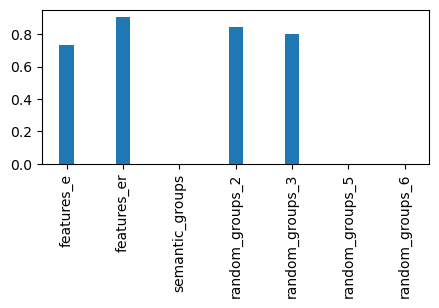

In [11]:
plt.figure(figsize=(5,2))
slack = 3
width = 1/(len(labels)*(len(data)+slack))
pos_0 = np.linspace(0,1,len(data[0])+1)[:-1]
for i,d in enumerate(data):
    plt.bar(pos_0+i*width, d, width=width)
plt.xticks(pos_0+((len(data)-1)*width/2), labels, rotation = 90);

# Contributions

In [12]:
mse_collector = {}

for ReaderType, target in zip(readerTypes, targets):
    reader = ReaderType('/mnt/idms/kdomokos/data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')
    reader.readAndCache()
    print("---------")
    print("Dataset:", reader.name)
    cols = reader.cols
    ncols = len(cols)

    trainer = utils.Trainer(
        cache_dir='models_clean',
        default_params={
            'objective': 'regression',
            'metric': 'mse',
            'boosting': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'verbose': -1,
            'device': 'cpu',
            'lambda_l2': 0.003,
            'early_stopping_round': 10,
            'num_boost_round': 100,
        },
        nocache_params={
            'num_threads': 20,
        }
    )
    evaluator = utils.Evaluator(reader, target)
    
    data_mse = {}

    for groupsize in [1,2,3,5,6]:
        np.random.seed(reader.seed)
        ngroups = len(cols)//groupsize
        if ngroups <= 2:
            continue
        mses_e = []
        mses_er = []
        print("Calculating random group", groupsize, "E^r mse...")
        for i in tqdm(range(100)):
            contribs_e = [evaluator.base_mse]
            contribs_er = [evaluator.base_mse]
            feature_perm = np.random.permutation(cols)
            groups = np.array_split(feature_perm, ngroups)[::-1] # array split puts longer groups first, lets switch the order
            groups_sofar = []
            for g in groups:
                groups_sofar.append(g)
                trainData = utils.TrainingData(reader, target, columns=[i for g in groups_sofar for i in g])
                
                booster = trainer.train_model(trainData)
                new_mse = evaluator.get_model_mse(booster)
                contribs_e.append(new_mse - np.sum(contribs_e))
                
                booster = trainer.train_model(trainData, {
                    'interaction_constraints': get_group_constraints(groups_sofar),
                })
                new_mse = evaluator.get_model_mse(booster)
                contribs_er.append(new_mse - np.sum(contribs_er))
                
                if len(contribs_e) > 5:
                    break
            mses_e.append(contribs_e)
            mses_er.append(contribs_er)
        data_mse['random_groups_'+str(groupsize)] = {
            'ngroups': ngroups,
            'mses_e':np.array(mses_e).mean(axis=0),
            'mses_er':np.array(mses_er).mean(axis=0),
            'base_mse':evaluator.base_mse,
        }
    mse_collector[reader.name] = data_mse

---------
Dataset: PM2.5 Data of Five Chinese Cities
Calculating random group 1 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 3 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

## Contributions of random groups in random order

In [13]:
for name, group_setups in mse_collector.items():
    print(name)
    for group, mse_info in group_setups.items():
        print(group)
        print(mse_info['mses_e']/mse_info['base_mse'])
        print(mse_info['mses_er']/mse_info['base_mse'])

PM2.5 Data of Five Chinese Cities
random_groups_1
[ 1.00000000e+00 -5.22282299e-04 -1.00183439e-02 -3.77411703e-02
 -5.16210750e-02 -4.41699794e-02]
[ 1.00000000e+00 -5.22282299e-04 -3.90890283e-03 -1.27623041e-02
 -1.68756670e-02 -1.10641070e-02]
random_groups_2
[ 1.         -0.01054063 -0.08936231 -0.08523114 -0.05696984 -0.02402596]
[ 1.         -0.01054063 -0.05150067 -0.04310268 -0.03273801 -0.01761537]
random_groups_3
[ 1.         -0.04828254 -0.13685175 -0.08099557]
[ 1.         -0.04828254 -0.08441696 -0.0651493 ]


In [14]:
# latex translate dict
ltd = {
    'random_groups_1': 'Individual features',
    'random_groups_2': 'Random groups of size 2',
    'random_groups_3': 'Random groups of size 3',
    'random_groups_5': 'Random groups of size 5',
    'random_groups_6': 'Random groups of size 6',
}
print("Grouping", *["$\phi_%d$"%i for i in range(1,6)], sep="&", end="\\\\\n")
for name, group_setups in mse_collector.items():
    print('\midrule')
    print("\multicolumn{6}{l}{%s}"%name, end="\\\\\n")
    print('\midrule')
    for group, mse_info in group_setups.items():
        print(ltd[group]+" ($E$)", *["%.4f"%f for f in mse_info['mses_e'][1:]/mse_info['base_mse']], sep=" & ", end="\\\\\n")
        print(ltd[group]+" ($E^r$)", *["%.4f"%f for f in mse_info['mses_er'][1:]/mse_info['base_mse']], sep=" & ", end="\\\\\n")

Grouping&$\phi_1$&$\phi_2$&$\phi_3$&$\phi_4$&$\phi_5$\\
\midrule
\multicolumn{6}{l}{PM2.5 Data of Five Chinese Cities}\\
\midrule
Individual features ($E$) & -0.0005 & -0.0100 & -0.0377 & -0.0516 & -0.0442\\
Individual features ($E^r$) & -0.0005 & -0.0039 & -0.0128 & -0.0169 & -0.0111\\
Random groups of size 2 ($E$) & -0.0105 & -0.0894 & -0.0852 & -0.0570 & -0.0240\\
Random groups of size 2 ($E^r$) & -0.0105 & -0.0515 & -0.0431 & -0.0327 & -0.0176\\
Random groups of size 3 ($E$) & -0.0483 & -0.1369 & -0.0810\\
Random groups of size 3 ($E^r$) & -0.0483 & -0.0844 & -0.0651\\


In [15]:
for name, group_setups in mse_collector.items():
    print(name)
    for group, mse_info in group_setups.items():
        print(group)
        print(mse_info['mses_e']/mse_info['base_mse'])
        print(mse_info['mses_er']/mse_info['base_mse'])

PM2.5 Data of Five Chinese Cities
random_groups_1
[ 1.00000000e+00 -5.22282299e-04 -1.00183439e-02 -3.77411703e-02
 -5.16210750e-02 -4.41699794e-02]
[ 1.00000000e+00 -5.22282299e-04 -3.90890283e-03 -1.27623041e-02
 -1.68756670e-02 -1.10641070e-02]
random_groups_2
[ 1.         -0.01054063 -0.08936231 -0.08523114 -0.05696984 -0.02402596]
[ 1.         -0.01054063 -0.05150067 -0.04310268 -0.03273801 -0.01761537]
random_groups_3
[ 1.         -0.04828254 -0.13685175 -0.08099557]
[ 1.         -0.04828254 -0.08441696 -0.0651493 ]


In [16]:
# should be monotonically decreasing for random groups in random order!

#### Collecting info for oversized contributions

In [17]:
collector = []
collector2 = []
collector3 = []
for ReaderType, target in zip(readerTypes, targets):
    reader = ReaderType('/mnt/idms/kdomokos/data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')
    reader.readAndCache()
    print("---------")
    print("Dataset:", reader.name)
    cols = reader.cols
    ncols = len(cols)

    trainer = utils.Trainer(
        cache_dir='models_clean',
        default_params={
            'objective': 'regression',
            'metric': 'mse',
            'boosting': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'verbose': -1,
            'device': 'cpu',
            'lambda_l2': 0.003,
            'early_stopping_round': 10,
            'num_boost_round': 100,
            'max_depth': 3,
        },
        nocache_params={
            'num_threads': 20,
        }
    )
    evaluator = utils.Evaluator(reader, target)

    for groupsize in [2]:
        np.random.seed(reader.seed)
        ngroups = len(cols)//groupsize
        if ngroups <= 2:
            continue
            
        print("Calculating random group", groupsize, "E^r mse...")
        for i in tqdm(range(100)):
            contribs_e = [evaluator.base_mse]
            contribs_er = [evaluator.base_mse]
            feature_perm = np.random.permutation(cols)
            groups = np.array_split(feature_perm, ngroups)[::-1] # array split puts longer groups first, lets switch the order
            groups = [list(i) for i in groups[:2]]

            trainData = utils.TrainingData(reader, target, columns=groups[0])
            booster = trainer.train_model(trainData)
            first_mse = evaluator.get_model_mse(booster)

            trainData = utils.TrainingData(reader, target, columns=groups[1])
            booster = trainer.train_model(trainData)
            second_mse = evaluator.get_model_mse(booster)

            trainData = utils.TrainingData(reader, target, columns=[i for g in groups for i in g])
            booster = trainer.train_model(trainData, {
                'interaction_constraints': get_group_constraints(groups),
            })
            both_mse = evaluator.get_model_mse(booster)

            cov = utils.get_group_cov(booster, reader.getTest(), get_group_constraints(groups))
    
            collector.append(((both_mse - first_mse)/evaluator.base_mse - (second_mse - evaluator.base_mse)/evaluator.base_mse, cov.min()))
            collector2.append((
                groups,
                first_mse-evaluator.base_mse, second_mse-evaluator.base_mse, both_mse-evaluator.base_mse,
                (both_mse - first_mse)/evaluator.base_mse - (second_mse - evaluator.base_mse)/evaluator.base_mse,
                 cov
            ))
            
            features = pd.Series(booster.feature_name())
            groups = [list(features[g].values) for g in get_group_constraints(groups)]
            group_masks = utils.get_feature_group_masks(booster, groups)
            tree_preds = utils.get_tree_predictions(booster, evaluator.eval)
            group_pred_parts = np.array([tree_preds.dot(mask) for mask in group_masks]).T
            
            second_part_mse = evaluator.get_mse(evaluator.eval_y, group_pred_parts[:, 1]-group_pred_parts[:, 1].mean() + evaluator.train_y.mean())
            second_part_mse = min(second_part_mse, second_mse)
            
            collector3.append(((both_mse - first_mse)/evaluator.base_mse - (second_part_mse - evaluator.base_mse)/evaluator.base_mse, cov.min()))
            
            if ((both_mse - first_mse)/evaluator.base_mse - (second_part_mse - evaluator.base_mse)/evaluator.base_mse) < 0:
                print("-----")
                print(groups)
                print(((both_mse - first_mse)/evaluator.base_mse - (second_part_mse - evaluator.base_mse)/evaluator.base_mse))
                print(cov)

---------
Dataset: PM2.5 Data of Five Chinese Cities
Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

-----
[['cbwd', 'TEMP'], ['precipitation', 'HUMI']]
-0.000753852572431768
[[246.93076493 -19.73635563]
 [-19.73635563 146.69496129]]
-----
[['DEWP', 'HUMI'], ['Iprec', 'cbwd']]
-0.00281304504150727
[[240.32378829 -21.71197672]
 [-21.71197672 200.34539151]]
-----
[['TEMP', 'DEWP'], ['Iprec', 'cbwd']]
-0.009008228661991177
[[235.0408762  -20.21351582]
 [-20.21351582 192.19716903]]


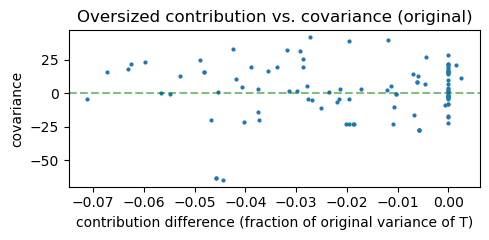

In [18]:
plt.figure(figsize=(5,2.5))
plt.scatter(*np.array(collector).T, s=4)
plt.title('Oversized contribution vs. covariance (original)')
plt.ylabel('covariance')
plt.xlabel('contribution difference (fraction of original variance of T)')
plt.tight_layout()
plt.axhline(0, color="g", alpha=0.5, linestyle="--")

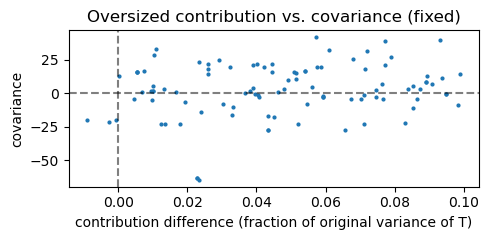

In [19]:
plt.figure(figsize=(5,2.5))
plt.scatter(*np.array(collector3).T, s=4)
plt.title('Oversized contribution vs. covariance (fixed)')
plt.ylabel('covariance')
plt.xlabel('contribution difference (fraction of original variance of T)')
plt.tight_layout()
plt.axhline(0, color="k", alpha=0.5, linestyle="--")
plt.axvline(0, color="k", alpha=0.5, linestyle="--")